# Semi-Supervised Learning
- MNIST data 사용
- Autoencoder Model
- Classifier Model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torchvision
import torchvision.transforms as T

import tensorflow as tf
import wandb

In [2]:
# seed 고정
import random
import torch.backends.cudnn as cudnn

def random_seed(seed_num):
    torch.manual_seed(seed_num)
    torch.cuda.manual_seed(seed_num)
    torch.cuda.manual_seed_all(seed_num)
    cudnn.benchmark = False
    cudnn.deterministic = True
    random.seed(seed_num)

random_seed(42)

In [3]:
wandb.login(key='')
run = wandb.init(project='semi-wupervised(MNIST)', name='training')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: greedjar74 (greedjar7498). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/kimhongseok/.netrc


In [4]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

In [5]:
print(len(train_images), len(test_images))
print(len(train_labels), len(test_labels))

60000 10000
60000 10000


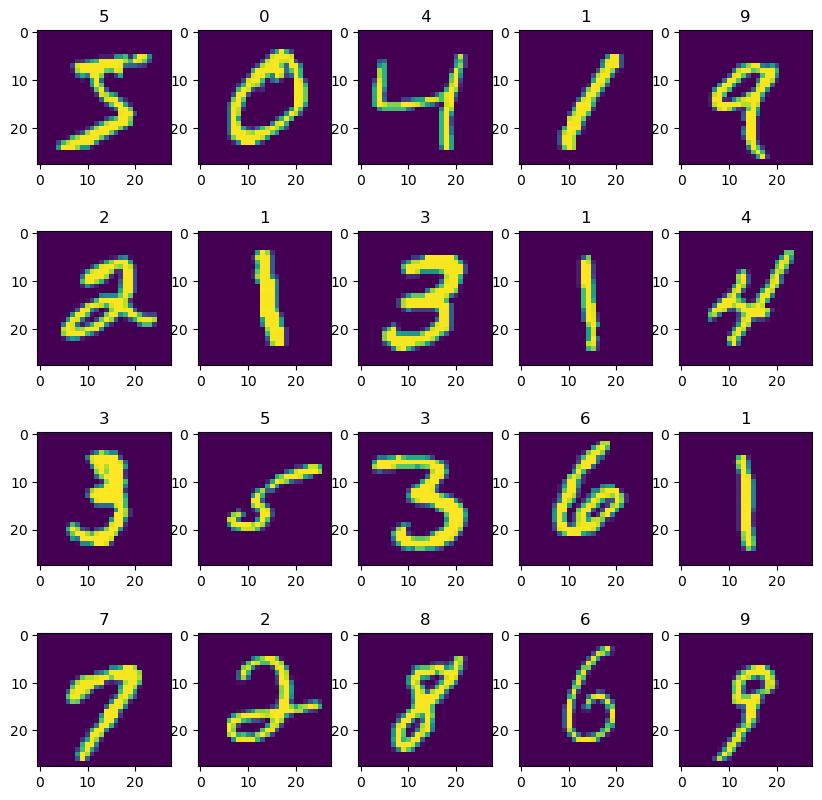

In [6]:
plt.figure(figsize=(10, 10))

for i in range(20):
    ax = plt.subplot(4, 5, i+1)
    plt.imshow(train_images[i])
    plt.title(train_labels[i])

## CustomDataset

In [7]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels, transform):
        super().__init__()
        self.data = list((transform(image), label) for image, label in zip(images, labels))

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

In [8]:
transform = T.ToTensor()

train_dataset = CustomDataset(train_images, train_labels, transform)
test_dataset = CustomDataset(test_images, test_labels, transform)

In [9]:
# train, valid data split

total_num = len(train_dataset)
train_num, valid_num = int(total_num*0.8), int(total_num*0.2)
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [train_num, valid_num])

In [10]:
batch_size = 32

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

##  Model

### AutoEnoder Model

In [11]:
class Autoencoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(28*28, 128),
            torch.nn.ReLU(True),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(True),
            torch.nn.Linear(64, 32),
            torch.nn.ReLU(True),
            torch.nn.Linear(32, 16),
            torch.nn.ReLU(True),
            torch.nn.Linear(16, 4)
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(4, 16),
            torch.nn.ReLU(True),
            torch.nn.Linear(16, 32),
            torch.nn.ReLU(True),
            torch.nn.Linear(32, 64),
            torch.nn.ReLU(True),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(True),
            torch.nn.Linear(128, 28*28)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        return encoded, decoded

### Classfier Model

In [12]:
class Classifier(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.layer = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1, stride=1),
            torch.nn.BatchNorm2d(num_features=16),
            torch.nn.ReLU(True),
            torch.nn.MaxPool2d(kernel_size=3, padding=1, stride=1),
            torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride=1),
            torch.nn.BatchNorm2d(num_features=32),
            torch.nn.ReLU(True),
            torch.nn.MaxPool2d(kernel_size=3, padding=1, stride=1),
            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=1),
            torch.nn.BatchNorm2d(num_features=64),
            torch.nn.ReLU(True),
            torch.nn.MaxPool2d(kernel_size=3, padding=1, stride=1),
            torch.nn.Flatten(),
            torch.nn.Linear(in_features=28*28*64, out_features=2048),
            torch.nn.ReLU(True),
            torch.nn.Linear(in_features=2048, out_features=1024),
            torch.nn.ReLU(True),
            torch.nn.Linear(in_features=1024, out_features=10),
            torch.nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = x.view(32, 1, 28, 28)
        output = self.layer(x)
        
        return output

## training 함수

In [13]:
def ae_training(model, train_dataloader, ae_criterion, ae_optimizer):
    model.train()

    tbar = tqdm(train_dataloader)
    for images, labels in tbar:
        y = images.view(-1, 28*28)
        encoded, decoded = model(images)
        loss = ae_criterion(decoded, y)

        ae_optimizer.zero_grad()
        loss.backward()
        ae_optimizer.step()

    return model

def clf_training(model, ae_model, train_dataloader, train_dataset, clf_criterion, clf_optimizer, epoch, num_epochs):
    model.train()
    train_loss = 0.0
    train_accuracy = 0

    tbar = tqdm(train_dataloader)
    for images, labels in tbar:
        encoded, decoded = ae_model(images)
        outputs = model(decoded)
        loss = clf_criterion(outputs, labels)

        clf_optimizer.zero_grad()
        loss.backward()
        clf_optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_accuracy += (predicted == labels).sum().item()

        tbar.set_description(f'Epoch/Num_Epochs [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}')

    train_loss = train_loss / len(train_dataloader)
    train_accuracy = train_accuracy / len(train_dataset)

    return model, train_loss, train_accuracy

def clf_evaluation(model, ae_model, valid_dataloader, valid_dataset, clf_criterion, epoch, num_epochs):
    model.eval()
    valid_loss = 0.0
    valid_accuracy = 0

    with torch.no_grad():
        tbar = tqdm(valid_dataloader)
        for images, labels in tbar:
            encoded, decoded = ae_model(images)
            outputs = model(decoded)
            loss = clf_criterion(outputs, labels)

            valid_loss += loss.item()
            max_prob, predicted = torch.max(outputs, 1)
            valid_accuracy += (predicted == labels).sum().item()

            tbar.set_description(f'Epoch/Num_Epochs [{epoch+1}/{num_epochs}], Valid Loss: {loss.item():.4f}')

    valid_loss = valid_loss / len(valid_dataloader)
    valid_accuracy = valid_accuracy / len(valid_dataset)

    return model, valid_loss, valid_accuracy

def ae_training_loop(model, train_dataloader, ae_criterion, ae_optimizer, num_epochs):
    for epoch in range(num_epochs):
        print(epoch+1)
        model = ae_training(model, train_dataloader, ae_criterion, ae_optimizer)

    return model

def clf_training_loop(model, ae_model, train_dataloader, valid_dataloader, train_dataset, valid_dataset, clf_criterion, clf_optimizer, num_epochs):
    for epoch in range(num_epochs):
        model, train_loss, train_accuracy = clf_training(model, ae_model, train_dataloader, train_dataset, clf_criterion, clf_optimizer, epoch, num_epochs)
        _, valid_loss, valid_accuracy = clf_evaluation(model, ae_model, valid_dataloader, valid_dataset, clf_criterion, epoch, num_epochs)

        monitoring_value = {'Train Loss': train_loss, 'Train Accuracy': train_accuracy, 'Valid Loss': valid_loss, 'Valid Accuracy': valid_accuracy}
        run.log(monitoring_value, step=epoch)
    
    return model

In [14]:
ae_model = Autoencoder()
clf_model = Classifier()

ae_criterion = torch.nn.MSELoss()
ae_optimizer = torch.optim.Adam(ae_model.parameters(), lr=0.001)

clf_criterion = torch.nn.NLLLoss()
clf_optimizer = torch.optim.Adam(clf_model.parameters(), lr=0.001)

ae_model = ae_training_loop(ae_model, train_dataloader, ae_criterion, ae_optimizer, 10)
clf_model = clf_training_loop(clf_model, ae_model, train_dataloader, valid_dataloader, train_dataset, valid_dataset, clf_criterion, clf_optimizer, 10)

1


  0%|          | 0/1500 [00:00<?, ?it/s]

2


  0%|          | 0/1500 [00:00<?, ?it/s]

3


  0%|          | 0/1500 [00:00<?, ?it/s]

4


  0%|          | 0/1500 [00:00<?, ?it/s]

5


  0%|          | 0/1500 [00:00<?, ?it/s]

6


  0%|          | 0/1500 [00:00<?, ?it/s]

7


  0%|          | 0/1500 [00:00<?, ?it/s]

8


  0%|          | 0/1500 [00:00<?, ?it/s]

9


  0%|          | 0/1500 [00:00<?, ?it/s]

10


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [15]:
run.finish()

Train Accuracy,▁▆▇▇███
Train Loss,█▂▂▁▁▁▁
Valid Accuracy,▁▂█▇▆▇█
Valid Loss,█▆▂▄▁▁▁
Train Accuracy,0.85846
Train Loss,0.4153
Valid Accuracy,0.85067
Valid Loss,0.45636


In [16]:
torch.save(ae_model.state_dict(), './ae_model.pt')

In [17]:
torch.save(clf_model.state_dict(), './clf_model.pt')